# Autoencoder Convolucional SSA - Two layers

Continuamos el estudio de SSA a primer orden, entrenamos un modelo convolucional utilizando imágenes de gráficos polares de la sección eficaz - $\sigma(\hat{k}_x, \hat{k}_y)$ -  generados por un modelo de dos capa rugosas bajo la aproximación SSA. Esta vez dejamos fija la geometría incidente. La potencia dispersada se calcula utilizando la aproximación SPM de primer orden, en los canales  HH, HV y VV.

In [1]:
# Monto los archivos al drive y cargo las funciones que voy a usar
#from google.colab import drive
#drive.mount('/content/drive/')

# integral gaussiana
# !cp "/content/drive/My Drive/Colab Notebooks/proyecto_pict/int_gauss.py" .
#!cp "/content/drive/My Drive/spm_layers/int_gauss.py" .

# # SPM Orden UNO
#!cp "/content/drive/My Drive/Small Slope Approx/resultados_SSA.py" .
#!cp "/content/drive/My Drive/Small Slope Approx/SSA_enero_2021.py" .

# Importo el modelo desarrollado por Marian: Código basado en Phys. Rev. B (63) 245411.
from two_rough_layers import *

In [2]:
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt

# Parámetros fijos
realizations = 20000

# Generamos los parámetros que vamos a variar aleatoriamente
k0 = 2*pi/.25
d = np.linspace(.5, 1.5, 50)
ep1, ep2 = np.arange(3, 53), np.arange(3, 53)
s1, s2 = np.linspace(.005, .025, 50), np.linspace(.005, .025, 50)
l1, l2 = np.linspace(.05, .25, 50), np.linspace(.05, .25, 50)
theta_i, phi_i = 45*np.pi/180, 0*np.pi/180

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 30)*np.pi / \
    180, np.linspace(0, 360, 30)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

# Sampleo y recorro: generamos un vector aleatorio que contenga los índices de los argumentos
rng = np.random.default_rng()
sigma = np.zeros((realizations, PHI.shape[0], PHI.shape[1], 3))


for i in range(realizations):
    # Genero una tira de indices aleatorios
    index = rng.integers(50, size=7)

    # Armo una tupla con los argumentos de S01
    args = (k0, THETA, PHI,
            theta_i, phi_i,
            ep1[index[0]], ep2[index[1]],
            s1[index[2]], l1[index[3]],
            s2[index[4]], l2[index[5]],
            d[index[6]])

    # Calculo la sección eficaz y agrego ruido
    s_O1 = suma_O1(*args)

    # v-pol
    s_vv = s_O1[0, 0]
    s_vv_noise = s_vv + rng.normal(0, .03*np.mean(s_vv), size=PHI.shape)

    # h-pol
    s_hh = s_O1[1, 1]
    s_hh_noise = s_hh + rng.normal(0, .03*np.mean(s_hh), size=PHI.shape)

    s_hv = s_O1[1, 0]
    s_hv_noise = s_hv + rng.normal(0, .03*np.mean(s_hv), size=PHI.shape)

    # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
    # Cuenta cantidad de NaNs
    cond = np.count_nonzero(np.isnan(s_hh_noise))
    if cond == 0:
        stack = np.dstack((s_hh_noise/np.max(np.abs(s_hh_noise)),
                           s_hv_noise/np.max(np.abs(s_hv_noise)),
                           s_vv_noise/np.max(np.abs(s_vv_noise))))
        sigma[i, :, :, :] = stack
    else:
        raise ValueError(f'Input contains NaN, infinity or a value too large for {s_hh_noise.dtype}')


In [3]:
# Chequeo el tamaño de los datos
shape = sigma.shape
print('Tamaños de los datos originales:', shape)

Tamaños de los datos originales: (20000, 30, 30, 3)


## Visualizo las soluciones generadas

(-1.0, 1.0)

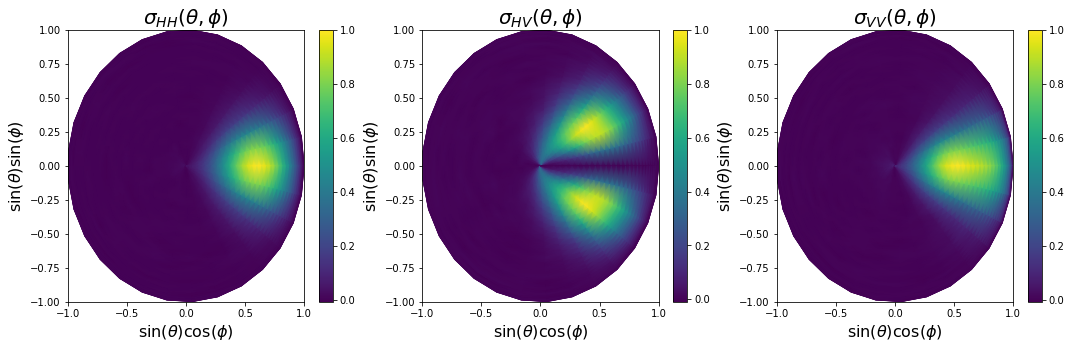

In [4]:
index = rng.integers(shape[0]) 
img = sigma[index,:,:,:]


fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 3, 1)
c = ax.pcolormesh(kx, ky, sigma[index,:,:,0],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal HV
ax = plt.subplot(1, 3, 2)
c = ax.pcolormesh(kx, ky, sigma[index,:,:,1],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal VV
ax = plt.subplot(1, 3, 3)
c = ax.pcolormesh(kx, ky, sigma[index,:,:,2],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{VV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

## Preparo los datos y defino el Autoencoder

In [5]:
from sklearn.model_selection import train_test_split

# Chequeo que no haya NaNs
print(f'Cantidad de NaNs en sigma: {np.count_nonzero(np.isnan(sigma))}')

# Separo en conjuntos de entrenamiento y testeo
sigma_train, sigma_test = train_test_split(sigma, test_size=.2)
print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

Cantidad de NaNs en sigma: 0
Tamaño de los datos de entrenamiento: (16000, 30, 30, 3)
Tamaño de los datos de testeo: (4000, 30, 30, 3)


Visualizo los elementos del conjuto de entrenamiento

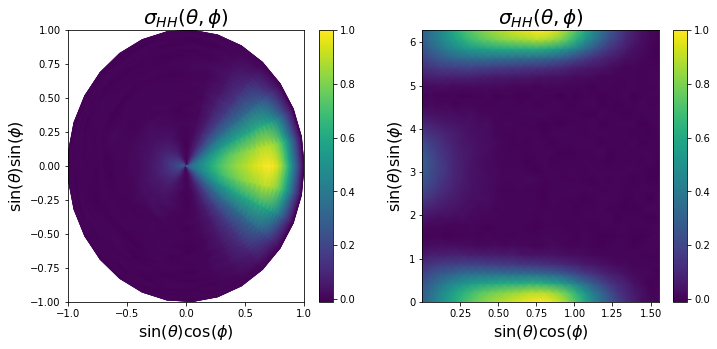

In [6]:
index = rng.integers(sigma_test.shape[0]) 
img = sigma_test[index,:,:,:]


fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 3, 1)
c = ax.pcolormesh(kx, ky, img[:,:,0],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# grafico cartesiano
ax = plt.subplot(1, 3, 2)
c = ax.pcolormesh(THETA, PHI, img[:,:,0],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (30,30,3)), 
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Conv2D(4, (4, 4), strides=2, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Flatten(),
                                            layers.Dense(units = 10*10*4, activation = 'relu'),
                                            #layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            #layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(units = 10*10*4, activation = 'relu'),
                                            
                                            layers.Reshape(target_shape=(10,10,4)),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(4, (4, 4), strides=2, activation="relu"),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation = 'relu'),
                                            layers.Conv2D(3, (4, 4), activation="sigmoid", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  

2021-11-05 19:07:45.124530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-05 19:07:45.124559: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


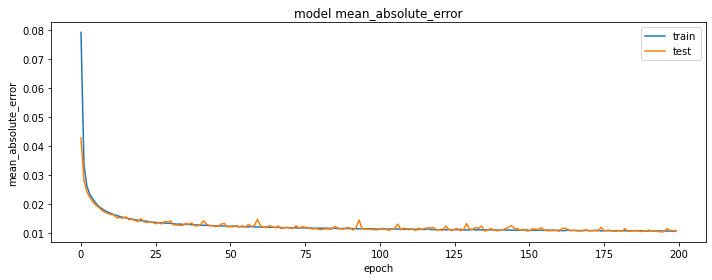

In [29]:
autoencoder = ConvAutoencoder(8)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])
history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 200,
            batch_size = 30,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))

# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.tight_layout()
plt.show()


In [9]:
# Guardamos los pesos de la red entrenada
import os
file_name= 'results/weights_lat_8_ssa_two_layer_ngi.h5'
folder = os.getcwd().split('/')[:-1]
weights_path = os.path.join('/'.join(folder), file_name)
autoencoder.save_weights(weights_path)

# Visualizamos los resultados 

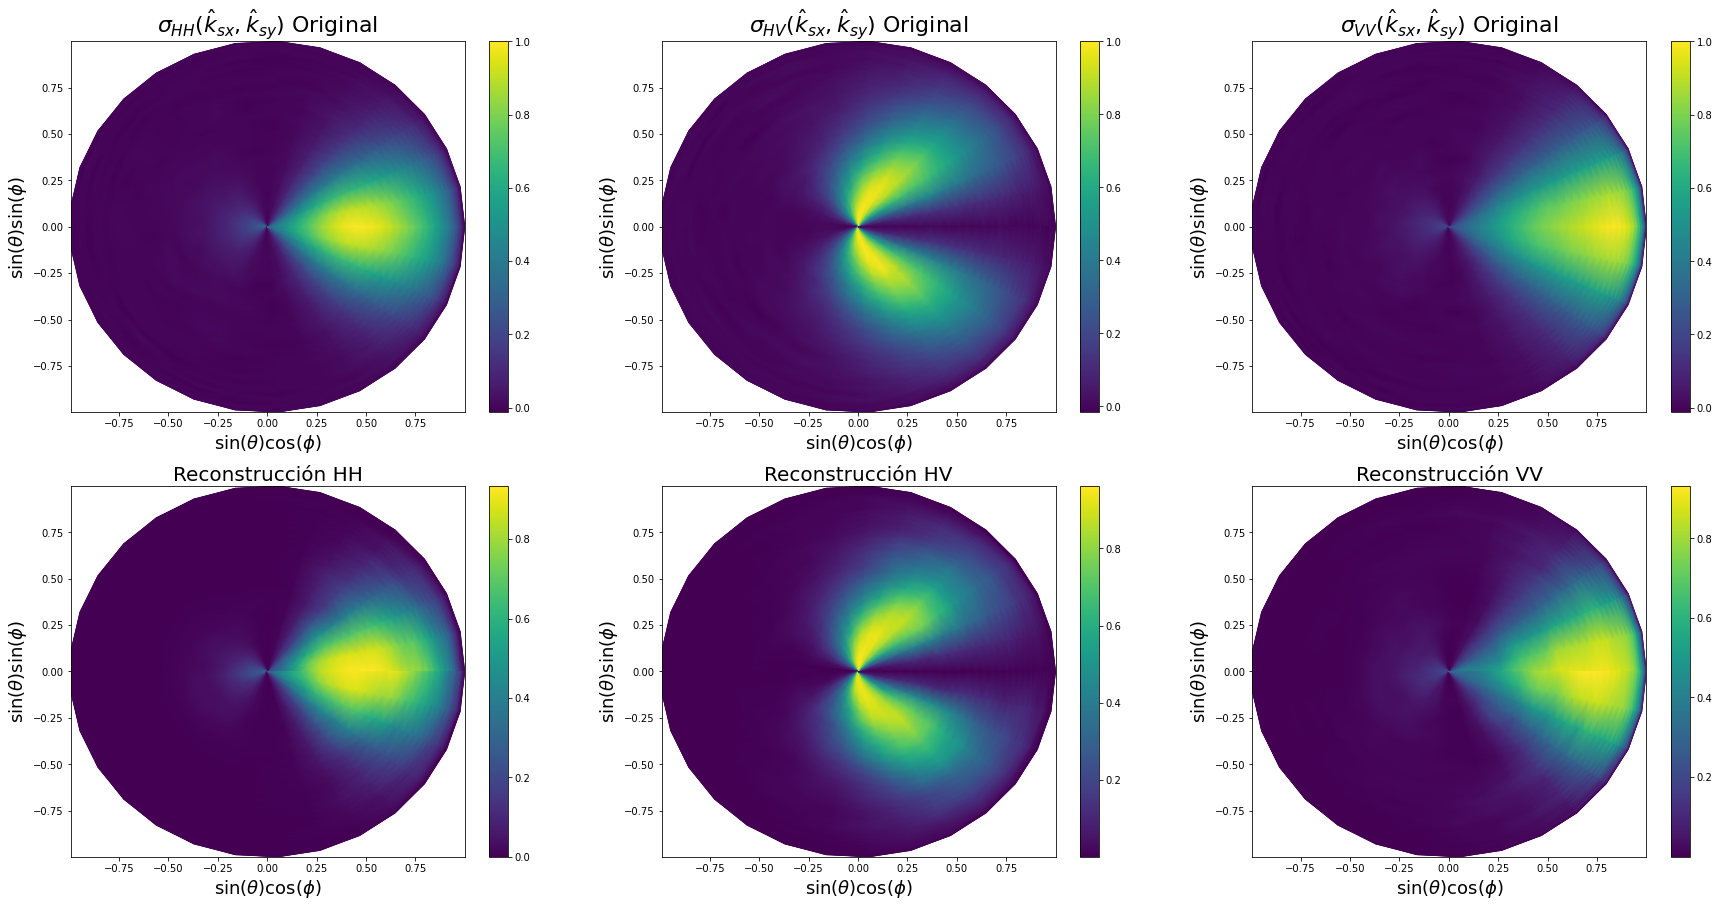

In [10]:
# Genero y decodifico imagenes de testeo
encoded_imgs = autoencoder.encoder(sigma_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 3
pol = {0: "HH", 1: "HV", 2: "VV"}
index = rng.integers(sigma_test.shape[0])

fig = plt.figure(figsize=(30, 15)) 
for i in range(n):
    # Imagen original
    s = sigma_test[index, :, :, i]
    s_min, s_max = s.min(), s.max()
    ax = plt.subplot(2, n, i + 1)
    c1 = ax.pcolormesh(kx, ky, s, shading = 'gouraud')
    plt.title(f"$\sigma_{{{pol[i]}}}(\hat{{k}}_{{sx}},\hat{{k}}_{{sy}})$ Original", fontsize = 22)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c1, ax=ax)

    # Imagen reconstruida
    s_recons = decoded_imgs[index, :, :, i]
    s_min, s_max = s_recons.min(), s_recons.max()
    ax = plt.subplot(2, n, i + 1 + n)
    c2 = ax.pcolormesh(kx, ky, s_recons, vmin=s_min,
                       vmax=s_max, shading = 'gouraud')
    plt.title(f"Reconstrucción {pol[i]}", fontsize = 20)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c2, ax=ax)
plt.show()
tf.keras.backend.clear_session()

## Variamos la dimensión del Espacio Latente

In [11]:
# Entreno varios autoencoders con distinta dim en espacio latente
min_abs_error, min_sqr_error  = [], []
avg_abs_error, avg_sqr_error = [], []

for lat_dim in range(1, 16):
  autoencoder = ConvAutoencoder(lat_dim)
  autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError(),
                    metrics = ['mean_absolute_error', 'mean_squared_error'])

  # Entreno el modelo
  history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 200,
            batch_size = 30,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))
  
  error_abs = np.array(history.history['val_mean_absolute_error'])
  error_sqr = np.array(history.history['val_mean_squared_error'])

  # Valor mínimo del error
  min_abs_error.append(error_abs.min())
  min_sqr_error.append(error_sqr.min())

  # Valor promedio del error en los ultimos 10 epochs
  avg_abs_error.append(np.mean(error_abs[-50:]))
  avg_sqr_error.append(np.mean(error_sqr[-50:]))

  tf.keras.backend.clear_session()

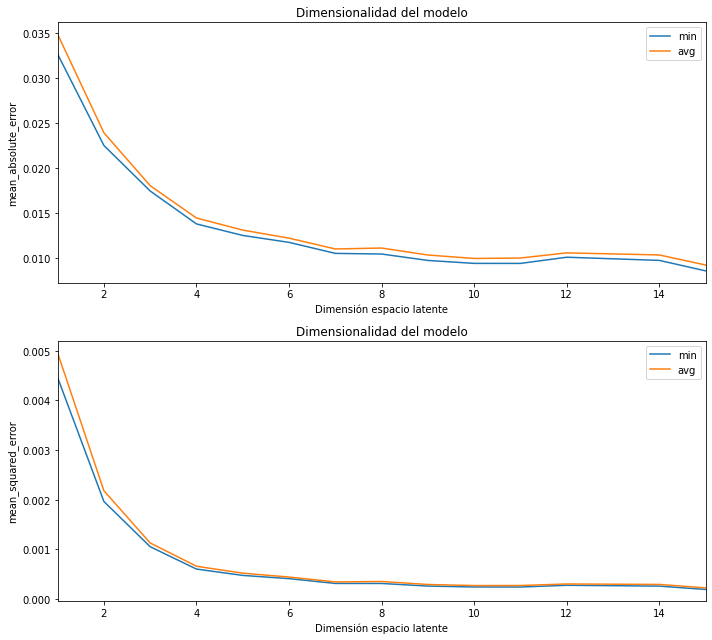

In [31]:
img_name= 'results/costo_SSA_two_layer_2_ngi.png'
img_path = os.path.join('/'.join(folder), img_name)

# Visualizo los errores -  Mean Absolute error
plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(range(1, 16), min_abs_error)
plt.plot(range(1, 16), avg_abs_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_absolute_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
 

# Mean Squared Error
plt.subplot(2,1,2)
plt.plot(range(1, 16), min_sqr_error)
plt.plot(range(1, 16), avg_sqr_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_squared_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
plt.savefig(img_path)
plt.show() 

In [32]:
# Guardo los datos
import pickle
cost_dict = {'MSE': (min_sqr_error, avg_sqr_error), 
             'MAE': (min_abs_error, avg_abs_error)}

path = os.path.join('/'.join(folder), 'results/cost_SSA_two_layer_ngi.pkl')             

with open(path, 'wb') as f:
  pickle.dump(cost_dict, f)

In [4]:
# Calculo la derivada segunda para encontrar el codo
diff_MSE = np.diff(cost_dict['MSE'], n=2)
diff_MAE = np.diff(cost_dict['MAE'], n=2)

print(f'Los índices que maximizan la curvatura para \
el error MAE son {np.argmax(diff_MAE, axis=1)}')
    
print(f'Los índices que maximizan la curvatura para \
el error MSE son {np.argmax(diff_MSE, axis=1)}')

Los índices que maximizan la curvatura para el error MAE son [0 0]
Los índices que maximizan la curvatura para el error MSE son [0 0]


In [3]:
import os
import pickle
import numpy as np

folder = os.getcwd().split('/')[:-2]
path = os.path.join('/'.join(folder), 'results/cost_SSA_two_layer_ngi.pkl')             

with open(path, 'rb') as f:
    cost_dict = pickle.load(f)